In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
from sksparse.cholmod import cholesky
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble, geometry_cy
#from patchmesh import *
#from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder ,**label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder,**label_kwargs)


In [3]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_indicator=[]
    refined=[]
    P = []
    #params['u_sol']=u_sol
    # params['ux']=ux
    # params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig, knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator.append(adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True))
            err_est[iter] = norm(err_indicator[-1])
            marked_patches = adap.doerfler_marking(err_indicator[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P_i = MP.patch_refine(h_ref=marked_patches, return_P = True)
            for i in range(len(P)):
                P[i]=P_i@P[i]
            P.append(P_i)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_indicator, refined, P

In [4]:
def Motor(deg,N,full=False):
    X=(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,2*N),)
    Y=2*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+2*(bspline.make_knots(deg,0.0,1.0,N),)
    kvs=list(itertools.product(X,Y))
    kvs=[(kv1,kv0) for kv0, kv1 in kvs] 
    #kvs = 45*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
    a,b,c,d,e,f=.3,1.,1.1,1.15,1.16,1.5
    th_m,th_air,th_fe=31.,2.,5. # 2*th_m + 4*th_air + 2*th_fe = 90!!!
    geos=[
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=a,r2=b,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),    
        
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=b,r2=c,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=c,r2=d,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=d,r2=e,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=e,r2=f,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),
    ]

    Fe = {0,1,2,3,4,5,6,7,8,9,13,17,18,19,20,21,22,23,24,25,26,36,37,38,39,40,41,42,43,44}
    Air={10,12,14,16,27,28,29,30,31,32,33,34,35}
    M1={11}
    M2={15}

    if full:
        kvs=4*kvs
        Fe = set().union(*[{x + 45*i for x in Fe} for i in range(4)])
        Air = set().union(*[{x + 45*i for x in Air} for i in range(4)])
        M1 = set().union(*[{x + 45*i for x in M1} for i in range(4)])
        M2 = set().union(*[{x + 45*i for x in M2} for i in range(4)])
        geos = [g for g in geos] + [g.rotate_2d(pi/2) for g in geos] + [g.rotate_2d(pi) for g in geos] + [g.rotate_2d(3/2*pi) for g in geos]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
    #patches = [(k, g) for k, g in zip(kvs,geos)]

    t=time.time()
    M = topology.PatchMesh(patches, domains={'M1':M1,'M2':M2,'Fe':Fe,'Air':Air})
    print('Detecting interfaces took ' + str(time.time()-t) + ' seconds.')
    
    M.rename_boundary(0,'D')
    if not full:                            #periodic boundary conditions
        M.set_boundary_id({'N':{(0,0),(9,0),(18,0),(27,0),(36,0),(8,1),(17,1),(26,1),(35,1),(44,1)}})
        #M.add_interface(0 ,0,0,8 ,1,0,(False,))
        #M.add_interface(9 ,0,0,17,1,0,(False,))
        #M.add_interface(18,0,0,26,1,0,(False,))
        #M.add_interface(27,0,0,35,1,0,(False,))
        #M.add_interface(36,0,0,44,1,0,(False,))
    return M
#M.set_boundary_id({'D1':{(0,2),(8,2),(16,2),(24,2)}})
#M.set_boundary_id({'D2':{(7,3),(15,3),(23,3),(31,3)}})

In [5]:
rho=1.28

nu = {'M1': 1e7/(4.344*pi), 'M2':1e7/(4.344*pi), 'Fe':1e5/(204*pi), 'Air': 1e7/(4*pi)}
#nu = {'M1': 1., 'M2': 1., 'Fe': 1., 'Air': 1.}

Ma_T = {'M1': lambda x,y: tuple(rho*nu['M1']*np.array([-y,x])/sqrt(x**2+y**2)), 
        'M2':lambda x,y: tuple(rho*nu['M2']*np.array([y,-x])/sqrt(x**2+y**2)), 
        'Fe':lambda x,y: (0.,0.), 
        'Air': lambda x,y: (0.,0.)}

j = {'M1': 0., 'M2': 0., 'Fe': 0., 'Air': 0.}

In [7]:
deg=4
M=Motor(deg,deg+1,full=False)

Detecting interfaces took 2.332399606704712 seconds.


In [8]:
%timeit assemble.detect_interfaces([p[0] for p in M.patches])

2.08 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit geometry_cy.pyx_detect_interfaces(M.geos)

2.07 s ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


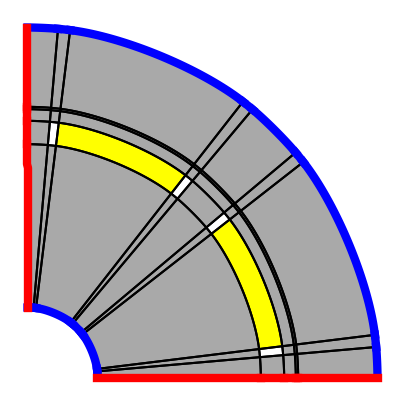

In [40]:
M.draw(knots=True, figsize=(5,5),color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'},bcolor={'D':'blue','N':'red'}, bwidth=6)
axis('off');
plt.savefig("material_motor.pdf", format="pdf", bbox_inches="tight")

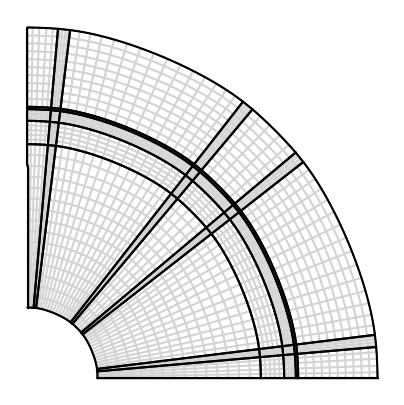

In [41]:
M.draw(knots=True, figsize=(5,5), bwidth=1)
axis('off');
plt.savefig("mesh_motor.pdf", format="pdf", bbox_inches="tight")

In [48]:
for deg, maxiter in zip((4,),(12,)):
    M_a=Motor(deg,deg+1,full=False)
    MP_a = assemble.Multipatch(M_a, automatch=True)
    uh_a=[]
    P_a=[]
    err_ind=[]
    numdofs_a =np.zeros(maxiter)
    err_est=np.zeros(maxiter)

    for i in range(maxiter):
        #MP_a.mesh.draw(knots=1,bwidth=0.01,size=(20,20))
        #plt.axis('off');
        #plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Motor/p2/i'+str(i)+'.png',bbox_inches='tight');
        #plt.show()
        print(i)
        bcs = MP_a.compute_dirichlet_bcs({'D':0.})
        Ah_a = sum([MP_a.assemble_volume('nu * inner(grad(u),grad(v)) * dx',arity=2,nu=nu[k],domain_id=k) for k in nu])
        F = sum([MP_a.assemble_volume('(j * v - inner(Ma_T,grad(v))) * dx',arity=1, domain_id=k, j=j[k], Ma_T = Ma_T[k], physical=True) for k in j],axis=0)
        Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
        Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
        #print(Ah.shape)
        LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
        t=time.time()
        uh_a.append(LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b)))
        print("Solving took "+str(time.time()-t)+" seconds.")
        numdofs_a[i] = MP_a.numdofs
        #print(MP_a.numdofs)

        if i < maxiter-1 :
            err_ind.append(adap.mp_resPois(MP_a,uh_a[-1],f=j,a=nu, M=Ma_T, neu_data={'N':0.}, physical=True))
            #print(err_ind[-1])
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_mark(err_ind[-1], theta=0.8, TOL=0.05)
            #print(marked_patches)
            marked_patches = {p:None for p in marked_patches}
            MP_a.h_refine(h_ref=marked_patches, return_P=False)
            #P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=False))
        # elif i == maxiter-2:
        #     P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
        # else:
        #     pass

    # for k in reversed(range(1,len(P_a))):
    #     P_a[k-1]=P_a[k]@P_a[k-1]

    # L2err_a = np.zeros(maxiter)
    # H1err_a = np.zeros(maxiter)
    # Aherr_a = np.zeros(maxiter)
    # for i in range(len(uh_a)-1):
    #     eh = P_a[i]@uh_a[i]-uh_a[-1]
    #     L2err_a[i] = eh @ Mh_a @ eh
    #     H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    #     Aherr_a[i] = eh @ Ah_a @ eh

    # L2err_a = sqrt(L2err_a)
    # H1err_a = sqrt(H1err_a)
    # Aherr_a = sqrt(Aherr_a)

    # np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

Detecting interfaces took 2.334186553955078 seconds.
setting up constraints took 0.12471151351928711 seconds.
Basis setup took 0.013067960739135742 seconds
0
Solving took 0.026180744171142578 seconds.
Residual contributions took 0.33795905113220215 seconds.
Jump contributions took 0.6326127052307129 seconds.
Refinement took 0.041762590408325195 seconds for 9 patches.
setting up constraints took 0.2323472499847412 seconds.
Basis setup took 0.02911853790283203 seconds
1
Solving took 0.04208517074584961 seconds.
Residual contributions took 0.5632028579711914 seconds.
Jump contributions took 1.2383203506469727 seconds.
Refinement took 0.12369680404663086 seconds for 19 patches.
setting up constraints took 0.4505281448364258 seconds.
Basis setup took 0.0523838996887207 seconds
2
Solving took 0.07209277153015137 seconds.
Residual contributions took 0.9961860179901123 seconds.
Jump contributions took 2.366474151611328 seconds.
Refinement took 0.1865248680114746 seconds for 22 patches.
setting

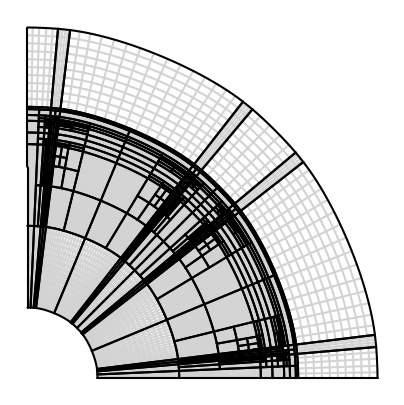

In [51]:
MP_a.mesh.draw(knots=True, figsize=(5,5), bwidth=0.1)
axis('off');
plt.savefig("refined_mesh_motor.pdf", format="pdf", bbox_inches="tight")

In [28]:
deg=4
M=Motor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=[7,6,6]
uh=[]
numdofs = np.zeros(maxiter[deg-2],dtype=float)
P=[]
return_P = True

for i in range(maxiter[deg-2]):
    print(i)
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    bcs = MP.compute_dirichlet_bcs({'D':0.})
    t=time.time()
    Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    print('assembly took '+str(time.time()-t)+' seconds.')
    t=time.time()
    uh.append(LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b)))
    print('solving took '+str(time.time()-t)+' seconds.')
    
    if i < maxiter[deg-2]-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter[deg-2]-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    MP.sanity_check()
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter[deg-2])
H1err = np.zeros(maxiter[deg-2])
Aherr = np.zeros(maxiter[deg-2])
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Detecting interfaces took 2.523030996322632 seconds.
Basis setup took 0.01647353172302246 seconds
0
5208
assembly took 1.1489317417144775 seconds.
solving took 0.0178070068359375 seconds.
Refinement took 0.0015292167663574219 seconds for 45 patches.
Basis setup took 0.022617101669311523 seconds
Prolongation took 0.09094381332397461 seconds
1
15168
assembly took 1.89449143409729 seconds.
solving took 0.06574058532714844 seconds.
Refinement took 0.001630544662475586 seconds for 45 patches.
Basis setup took 0.04467296600341797 seconds
Prolongation took 0.1192934513092041 seconds
2
50688
assembly took 3.8496780395507812 seconds.
solving took 0.25252556800842285 seconds.
Refinement took 0.002698659896850586 seconds for 45 patches.
Basis setup took 0.10209846496582031 seconds
Prolongation took 0.17913246154785156 seconds
3
184128
assembly took 10.142468929290771 seconds.
solving took 1.0553646087646484 seconds.
Refinement took 0.0020127296447753906 seconds for 45 patches.
Basis setup took 0.

In [6]:
for deg, maxiter in zip((4,),(10,)):
    M_geo=Motor(deg,deg+1)
    MP_geo = assemble.Multipatch(M_geo, automatch=True)
    uh_geo=[]
    numdofs_geo = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    Time_mesh_geo = np.zeros(maxiter)
    Time_solve_geo = np.zeros(maxiter)

    for i in range(maxiter):
        print(i)
        numdofs_geo[i] = MP_geo.numdofs
        print(MP_geo.numdofs)
        bcs = MP_geo.compute_dirichlet_bcs({'D':0.})
        t=time.time()
        Ah = sum([MP_geo.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP_geo.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
        Kh = MP_geo.assemble_volume(vform.stiffness_vf(2))
        Mh = MP_geo.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        print('assembly took '+str(time.time()-t)+' seconds.')
        t=time.time()
        uh_geo.append(LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b)))
        print('solving took '+str(time.time()-t)+' seconds.')

        if i < maxiter-2 :
            if i%5 == 0:
                P.append(MP_geo.h_refine(h_ref=-1, return_P=return_P))
            else:
                P.append(MP_geo.h_refine(h_ref='q', return_P=return_P))
        elif i == maxiter[deg-2]-2:
            P.append(MP_geo.p_refine(p_inc=1, return_P=return_P))
        else:
            pass
        MP_geo.sanity_check()

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err_geo = np.zeros(maxiter)
    H1err_geo = np.zeros(maxiter)
    Aherr_geo = np.zeros(maxiter)

    for i in range(len(uh_geo)-1):
        eh = P[i]@uh_geo[i]-uh_geo[-1]
        L2err_geo[i] = eh @ Mh @ eh
        H1err_geo[i] = eh @ Kh @ eh + L2err_geo[-1]
        Aherr_geo[i] = eh @ Ah @ eh

    L2err_geo = sqrt(L2err_geo)
    H1err_geo = sqrt(H1err_geo)
    Aherr_geo = sqrt(Aherr_geo)

    np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt', np.c_[[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]])

Detecting interfaces took 2.5886900424957275 seconds.
setting up constraints took 0.14429140090942383 seconds.
Basis setup took 0.018550395965576172 seconds
0
5208
assembly took 1.2975225448608398 seconds.
solving took 0.021170616149902344 seconds.
Refinement took 0.0015575885772705078 seconds for 45 patches.
setting up constraints took 0.17214632034301758 seconds.
Basis setup took 0.02872157096862793 seconds
Prolongation took 0.09147500991821289 seconds
1
15168
assembly took 2.002290725708008 seconds.
solving took 0.0713491439819336 seconds.
Refinement took 0.0018584728240966797 seconds for 45 patches.
setting up constraints took 0.18317866325378418 seconds.
Basis setup took 0.030100345611572266 seconds
Prolongation took 0.09054017066955566 seconds
2
18656


KeyboardInterrupt: 

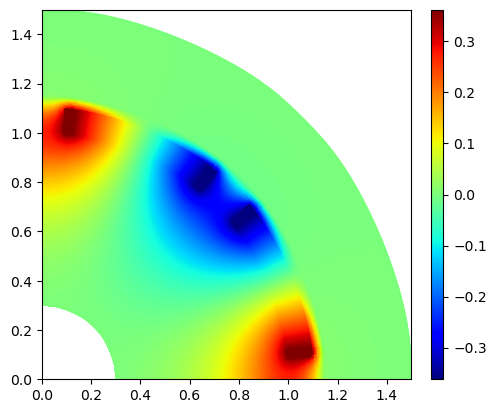

Plotting took 8.287397623062134 seconds.


In [21]:
t=time.time()
MP_a.plot(uh_a[-1], cmap='jet')
print('Plotting took '+str(time.time()-t)+' seconds.')

/tmp/ipykernel_8720/3687600441.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot=plt.pcolormesh(XY[...,0], XY[...,1], data, vmax=10, vmin=0, cmap='jet')


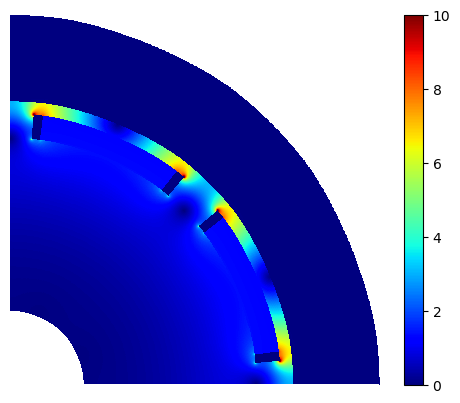

In [24]:
u_loc = MP_a.Basis@uh_a[-1]
u_max=max(u_loc)
u_min=min(u_loc)
res=(150,150)

for p in range(MP_a.numpatches):
    kvs=MP_a.mesh.kvs[p]
    geo=MP_a.mesh.geos[p]
    u_p = u_loc[MP_a.N_ofs[p]:MP_a.N_ofs[p+1]]
    u = bspline.BSplineFunc(kvs=kvs, coeffs=u_p)
    u_grad = geometry.BSplineFunc(kvs, u_p).transformed_jacobian(geo)
    grd = tuple(np.linspace(s[0], s[1], r) for (s,r) in zip(geo.support, res))
    XY = utils.grid_eval(geo, grd)
    data = u_grad.grid_eval(grd)
    data = norm(data,axis=2)
    #print(data)
   #print(data.min(),data.max())
    #data=u.grid_eval(grd)
    #print(grd)
    plot=plt.pcolormesh(XY[...,0], XY[...,1], data, vmax=10, vmin=0, cmap='jet')
    #plot.set_edgecolor('face')
    plot.set_rasterized(True)

    plt.axis('scaled');
    plt.axis('off');
    #print(data.shape)
    #vis.plot_quiver(lambda x,y: (uy(x,y),-ux(x,y)) , geo=geo, res=3)
    #vis.plot_field(lambda x,y: np.sqrt(u_grad(x,y)[0]**2+u_grad(x,y)[1]**2), geo=geo,vmin = u_min, vmax=u_max)
    #vis.plot_field(u, geo=geo, vmin = u_min, vmax=u_max)
plt.colorbar();
plt.savefig('/home/wolfman/Pictures/Motor/solution_norm_b.pdf',bbox_inches='tight');
plt.show()


In [49]:
XY[...,0].shape

(80, 80)

In [50]:
data.shape

(80, 80)

In [39]:
MP_a.function(uh_a[-1])

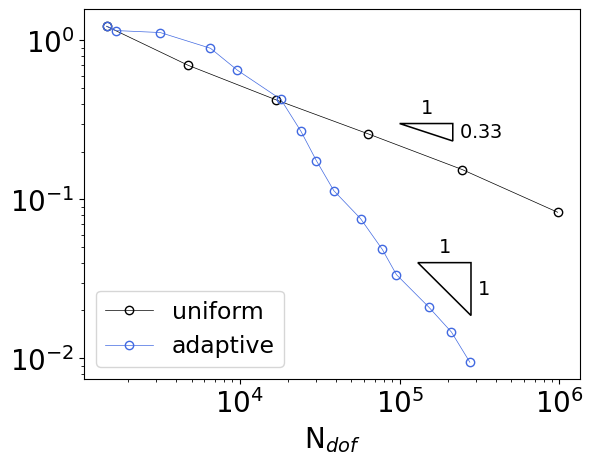

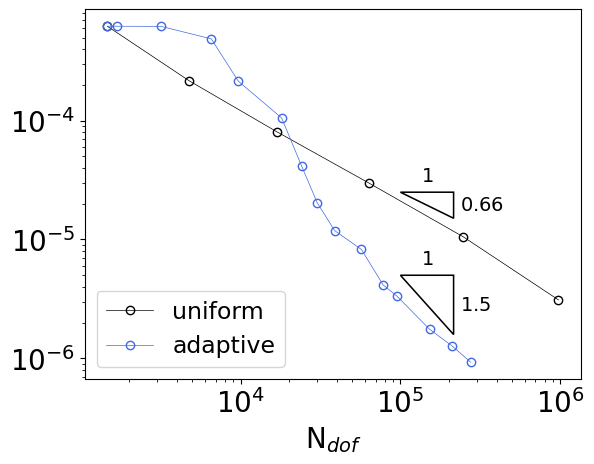

In [42]:
deg=2
[numdofs,H1err,L2err,Aherr]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-1], H1err_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniform','adaptive'],loc='lower left',prop={'size': 17})
plt.xlabel("N$_{dof}$", size=20)

draw_loglog_slope(fig,ax,(1e5,3*1e-1),1.5,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1.3*1e5,4*1e-2),1.5,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-4], L2err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniform','adaptive'],loc='lower left',prop={'size': 17})
plt.xlabel("N$_{dof}$", size=20)

draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1.5,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e5,5*1e-6),1.5,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#fig, ax = plt.subplots()
# plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_geo[:-1], Aherr_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')
plt.show()

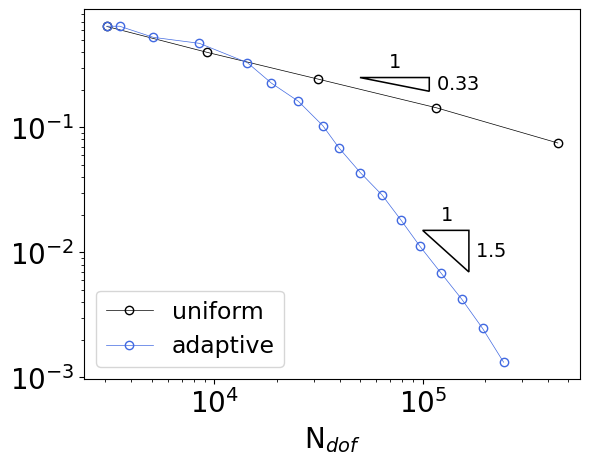

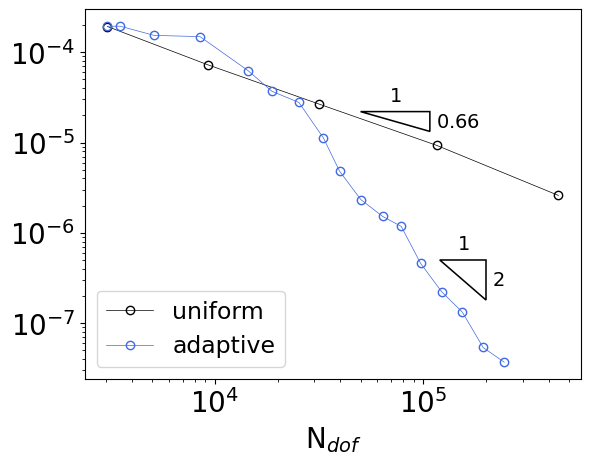

In [32]:
deg=3
[numdofs,H1err,L2err,Aherr]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-2], H1err_geo[:-2], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniform','adaptive'],loc='lower left',prop={'size': 17})
plt.xlabel("N$_{dof}$",size=20)

draw_loglog_slope(fig,ax,(5*1e4,2.5*1e-1),1.5,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e5,1.5*1e-2),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-2], L2err_geo[:-2], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniform','adaptive'],loc='lower left',prop={'size': 17})
plt.xlabel("N$_{dof}$", size=20)

draw_loglog_slope(fig,ax,(5*1e4,2.2*1e-5),1.5,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1.2*1e5,5*1e-7),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')
plt.show()

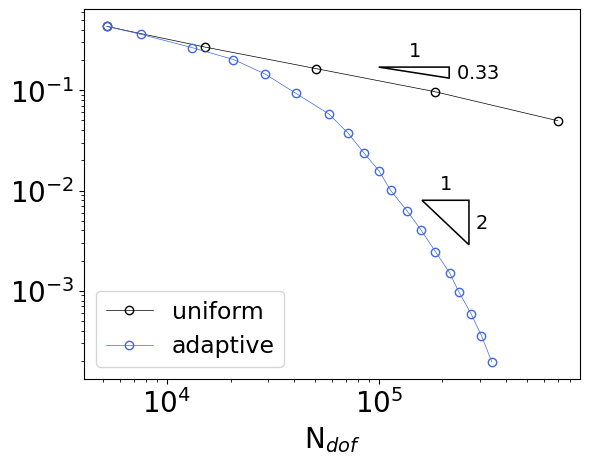

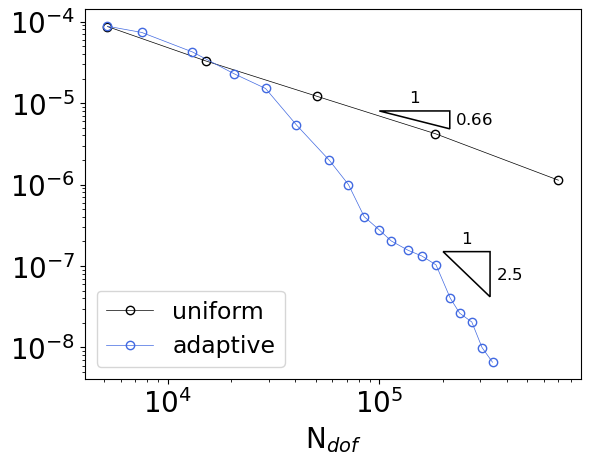

In [10]:
deg=4
[numdofs,H1err,L2err,Aherr]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')
fig, ax = plt.subplots()

plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:], 0.6*numdofs_a[:]**(-1/3), linestyle='--',color='black',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:-1], H1err_a[:-1], '--',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-3], H1err_geo[:-3], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniform','adaptive'],loc='lower left',prop={'size': 17})
plt.xlabel("N$_{dof}$",size=20)

draw_loglog_slope(fig,ax,(1e5,1.7*1e-1),1.5,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1.6*1e5,8*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None,label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-3], L2err_geo[:-3], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniform','adaptive'],loc='lower left',prop={'size': 17})
plt.xlabel("N$_{dof}$",size=20)

draw_loglog_slope(fig,ax,(1e5,8*1e-6),1.5,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, zorder=None, label_kwargs={'fontsize':12})
draw_loglog_slope(fig,ax,(2*1e5,1.5*1e-7),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':12}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')
plt.show()

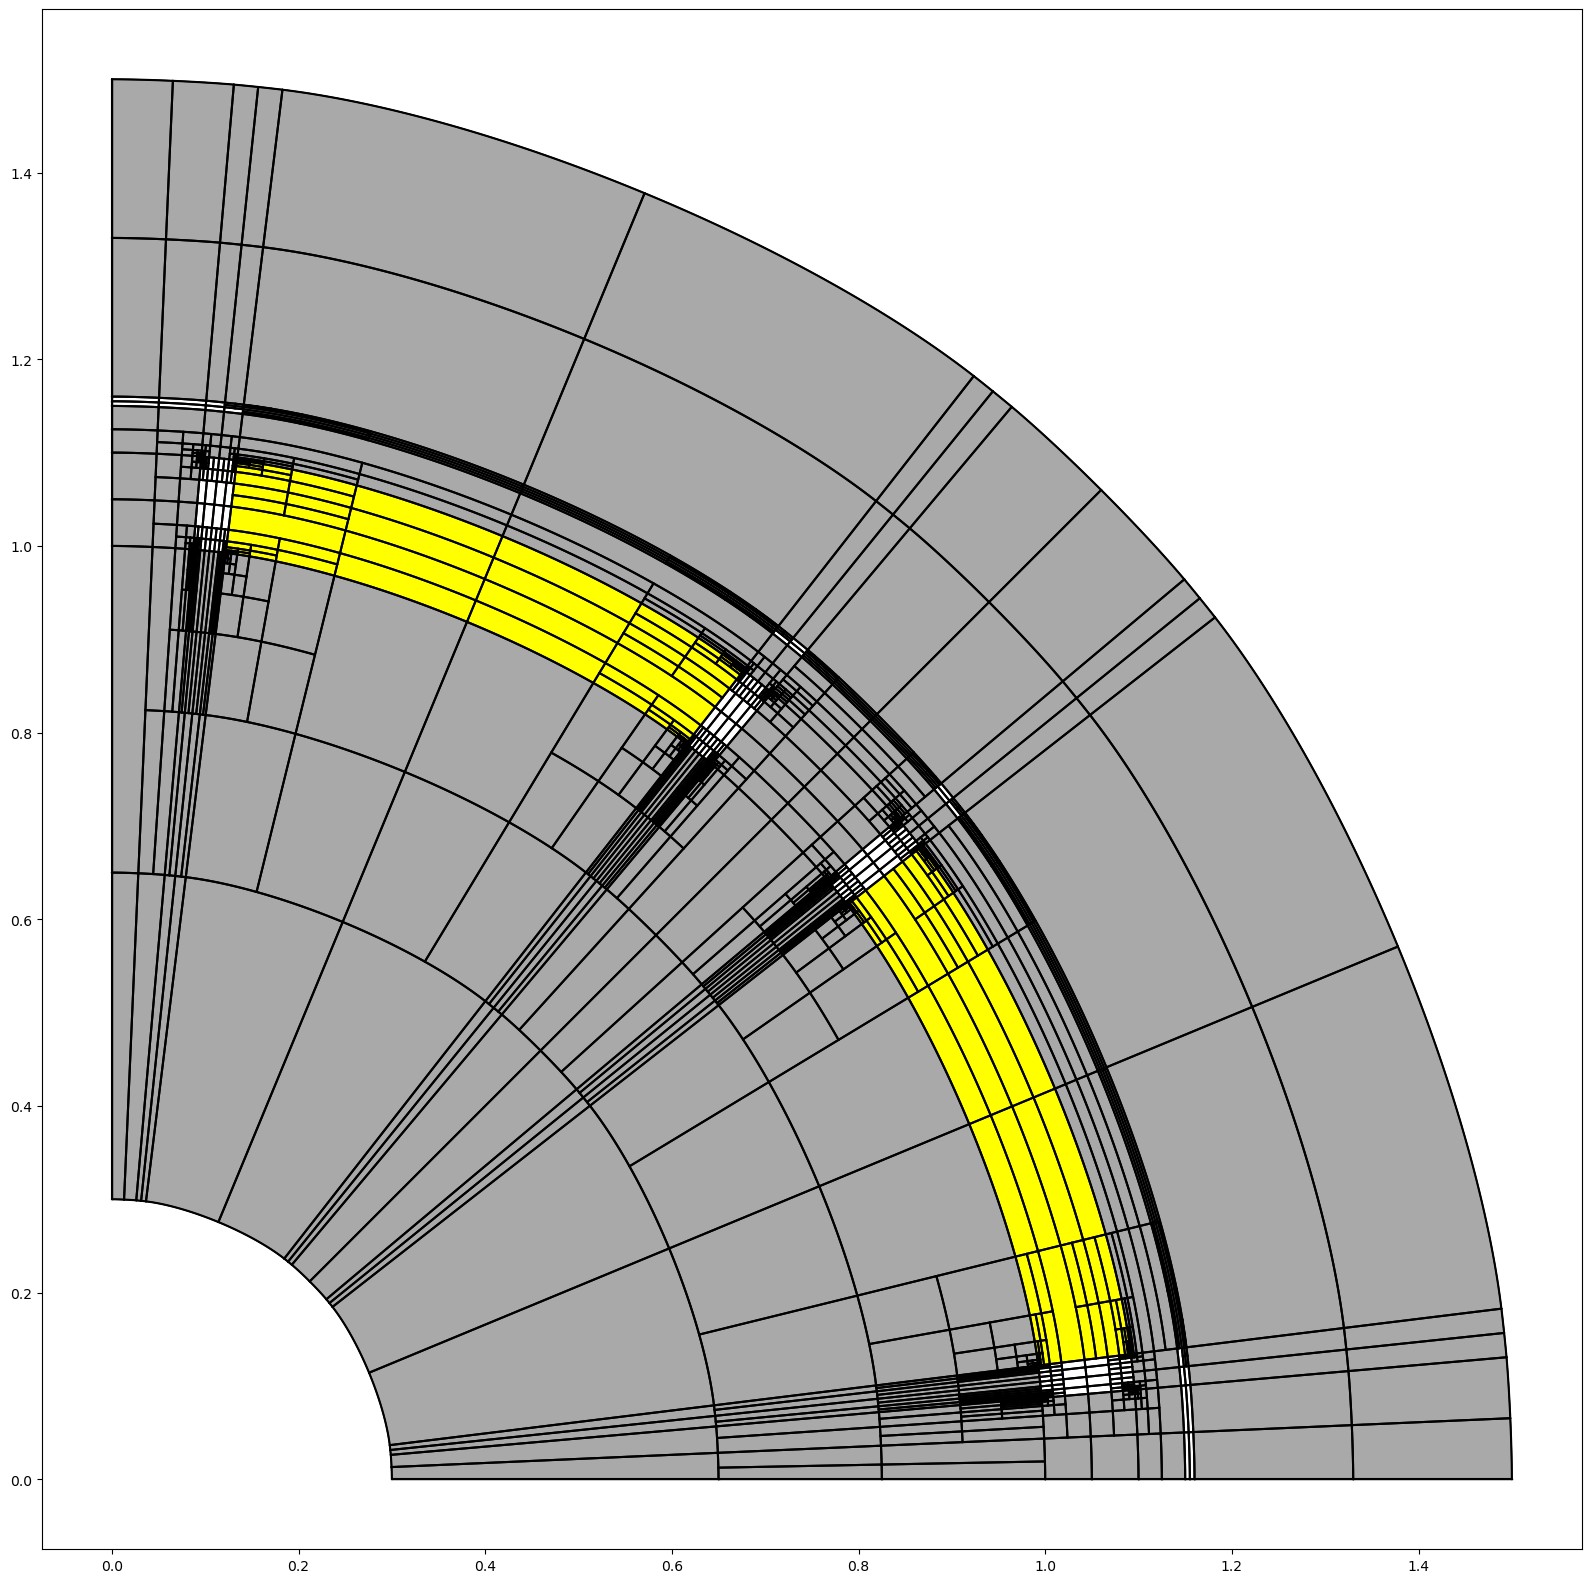

In [17]:
MP_a.mesh.draw(figsize=(20,20),color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'})

In [148]:
len(MP_a.mesh.domains['Air'])

736

In [8]:
marked=adap.doerfler_marking(err,theta=0.8)

In [20]:
Ma_T['M1'](1,1)

(-663216.4391580891, 663216.4391580891)

In [18]:
deg=2
M=Motor(deg,deg+1,full=False)
MP=assemble.Multipatch(M, automatch=True)
bcs = MP.compute_dirichlet_bcs({0:0.})
Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
F = sum([MP.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
uh = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

Detecting interfaces took 2.6801695823669434 seconds.
Basis setup took 0.013472318649291992 seconds


In [40]:
M=Motor(4,5)

Detecting interfaces took 2.7163403034210205 seconds.


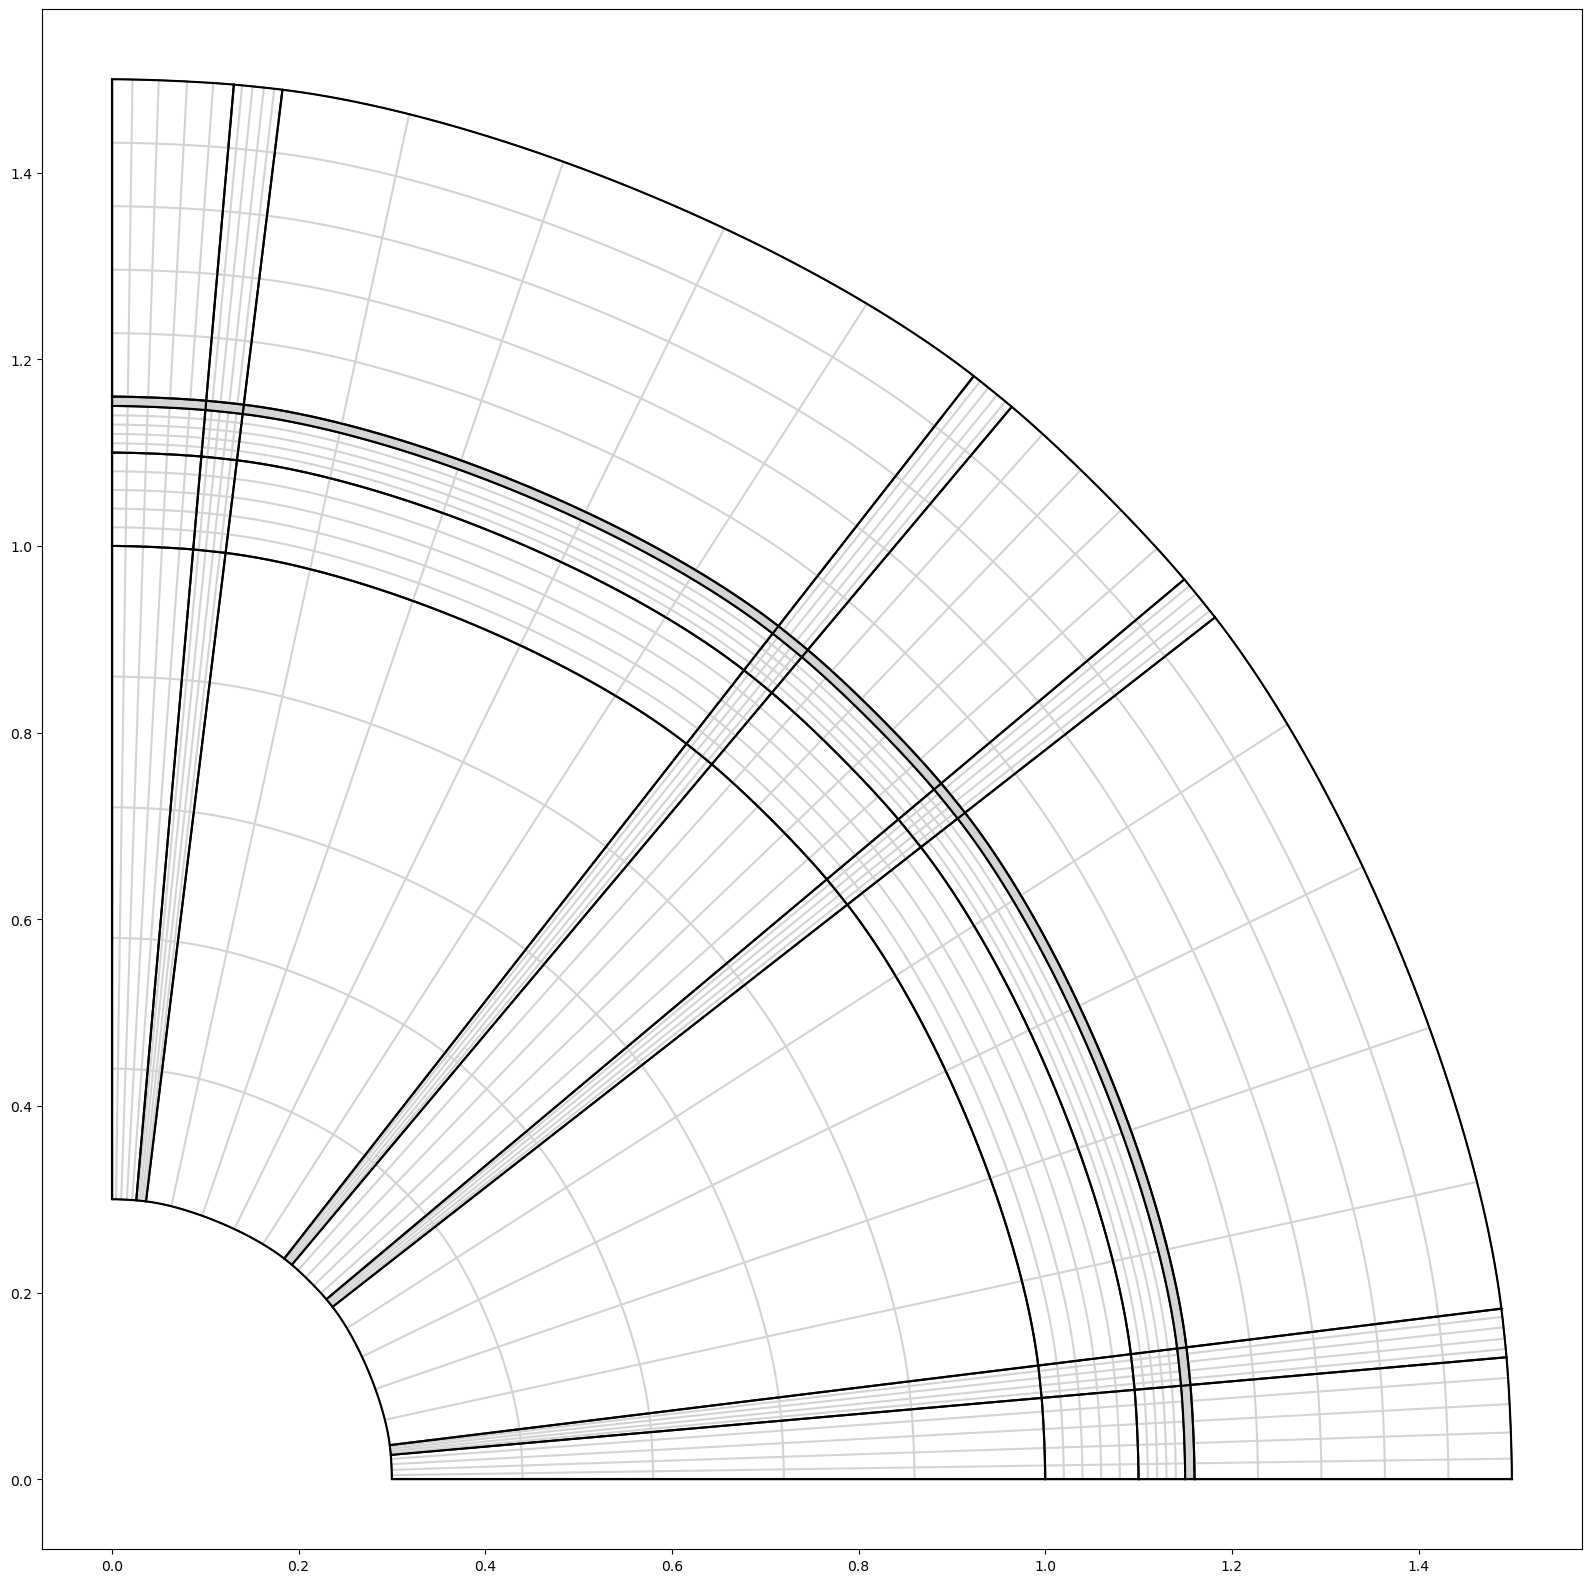

In [41]:
M.draw(figsize=(20,20),knots=True)
#plt.axis('off')
#MP.plot(uh, cmap='gnuplot2', axis='scaled')
#plt.axis('off')

In [19]:
M=topology.PatchMesh([(2*(bspline.make_knots(2,0.0,1.0,4),),geometry.unit_square())])
MP=assemble.Multipatch(M, automatch=True)

Basis setup took 0.0022804737091064453 seconds


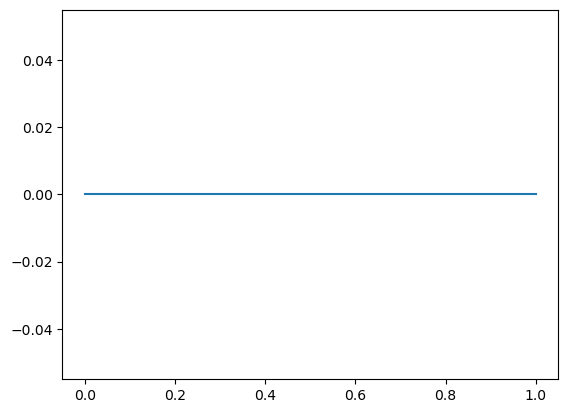

In [21]:
plt.plot([0.0,0.0])

In [3]:
u_ = MP.L2projection(lambda x,y: x**2+y**2)

AttributeError: 'Figure' object has no attribute 'get_array'

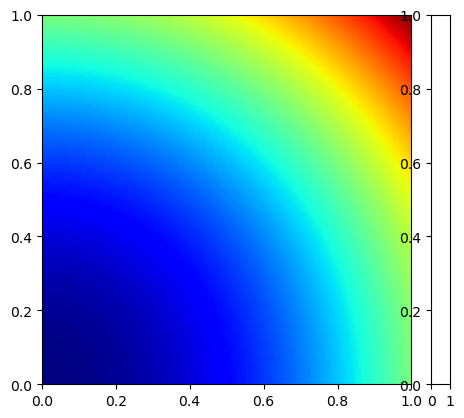

In [4]:
MP.plot(plt.figure(),u_)

In [5]:
fig=plt.figure()

<Figure size 640x480 with 0 Axes>